In [141]:
import triton
import triton.language as tl
import torch
import torch.nn.functional as F
from triton.runtime import driver

In [142]:
DEVICE = torch.device(f'cuda:{torch.cuda.current_device()}')

In [143]:
properties = driver.active.utils.get_device_properties(DEVICE.index)

In [144]:
properties

{'max_shared_mem': 101376,
 'max_num_regs': 65536,
 'multiprocessor_count': 64,
 'warpSize': 32,
 'sm_clock_rate': 1695000,
 'mem_clock_rate': 8001000,
 'mem_bus_width': 384}

In [244]:
@triton.autotune(
    configs=[
        triton.Config({'BLOCK_SIZE': 8}, num_stages=3, num_warps=1),
        triton.Config({'BLOCK_SIZE': 4}, num_stages=3, num_warps=1),
        triton.Config({'BLOCK_SIZE': 16}, num_stages=3, num_warps=1),
        triton.Config({'BLOCK_SIZE': 8}, num_stages=8, num_warps=1),
        triton.Config({'BLOCK_SIZE': 4}, num_stages=8, num_warps=1),
        triton.Config({'BLOCK_SIZE': 32}, num_stages=8, num_warps=1),
    ],
    key=['height', 'width', 'stride', 'kH', 'kW'],
)
@triton.jit
def conv2d_kernel(input_ptr: torch.Tensor, kernel_ptr: torch.Tensor, output: torch.Tensor, 
           height: int, width: int,  stride: int, kH: int, kW: int, 
           max_kH: tl.constexpr, max_kW: tl.constexpr, BLOCK_SIZE: tl.constexpr, num_stages: tl.constexpr): 
    
    tile_row = tl.program_id(0)
    tile_col = tl.program_id(1)
    
    out_height = (height - kH) // stride + 1
    out_width = (width - kW) // stride + 1
    
    OUT_TILE_HEIGHT = BLOCK_SIZE - kH + 1
    OUT_TILE_WIDTH = BLOCK_SIZE - kW + 1
    
    out_tile_row = tile_row * OUT_TILE_HEIGHT
    out_tile_col = tile_col * OUT_TILE_WIDTH
    
    kernel_row_offset = tl.arange(0, max_kH)
    
    kernel_col_offset = tl.arange(0, max_kW)

    # Create a mask for valid kernel indices.
    kernel_mask = (kernel_row_offset[:, None] < kH) & (kernel_col_offset[None, :] < kW)
    # Load a full kernel block using masked load.
    kernel_block = tl.load(
        kernel_ptr + kernel_row_offset[:, None] * kW + kernel_col_offset[None, :],
        mask=kernel_mask, other=0.0
    )
    
    
    for i in tl.range(0, OUT_TILE_HEIGHT, num_stages=num_stages):
        for j in tl.range(0, OUT_TILE_WIDTH, num_stages=num_stages):
            # acc = 0.0
            out_row = out_tile_row + i
            out_col = out_tile_col + j
            if out_row < out_height and out_col < out_width:
                input_row = out_row * stride
                input_col = out_col * stride
                
                patch_ptr = input_ptr + input_row * width + input_col
                input_patch = patch_ptr + kernel_row_offset[:, None] * width + kernel_col_offset[None, :]
                mask = (input_row + kernel_row_offset[:, None] < height) & (input_col + kernel_col_offset[None, :] < width) & kernel_mask
                input_block = tl.load(input_patch, mask = mask, other=0.0)
                acc = tl.sum(input_block * kernel_block)
                tl.store(output + out_row * out_width + out_col, acc)
                
                
    

In [245]:
def conv2d(input_tensor: torch.Tensor, kernel_tensor: torch.Tensor,
           height: int, width: int, kH: int, kW: int, stride: int):
    
    out_height = (height - kH) // stride + 1
    out_width = (width - kW) // stride + 1
    output_tensor = torch.empty(out_height, out_width, device='cuda', dtype=torch.float32)
    # Compute grid dimensions based on tile size.
    OUT_TILE_HEIGHT = BLOCK_SIZE - kH + 1
    OUT_TILE_WIDTH  = BLOCK_SIZE - kW + 1
    num_tile_rows = (out_height + OUT_TILE_HEIGHT - 1) // OUT_TILE_HEIGHT
    num_tile_cols = (out_width + OUT_TILE_WIDTH - 1) // OUT_TILE_WIDTH

    # The grid is 2D.
    grid = (num_tile_rows, num_tile_cols)
    max_kH, max_kW = triton.next_power_of_2(kH), triton.next_power_of_2(kW)
    
    conv2d_kernel[grid](input_tensor, kernel_tensor, output_tensor,
    height, width, stride, kH, kW, max_kH, max_kW)
    
    return output_tensor


In [246]:
# Example dimensions and hyperparameters.
height, width = 2048, 2048     # Input dimensions.
kH, kW = 3, 3                # Kernel dimensions.
stride = 1
input_tensor = torch.randn(height, width, device='cuda', dtype=torch.float32)
kernel_tensor = torch.randn(kH, kW, device='cuda', dtype=torch.float32)
output_tensor = conv2d(input_tensor, kernel_tensor, height=height, width=width, kH=kH, kW=kW, stride=stride)
torch_output = F.conv2d(input_tensor[None, None, :, :], kernel_tensor[None, None, :, :]).squeeze()
if torch.allclose(output_tensor, torch_output, rtol=1e-5, atol=1e-5):
    print("✅ Triton and Torch conv2d implementations match")
else:
    print("❌ Triton and Torch conv2d implementations differ")

✅ Triton and Torch conv2d implementations match


In [247]:
output_tensor

tensor([[-4.1144,  1.2930, -0.5243,  ...,  1.9028,  3.2603,  5.0262],
        [ 2.3319, -4.1622, -1.1762,  ..., -2.6686, -1.4141,  7.0003],
        [ 4.0989,  0.8218, -3.3463,  ..., -7.7203,  1.1476, -0.9271],
        ...,
        [-0.5928,  3.2720, -8.5120,  ..., -1.5937,  1.4196,  2.0563],
        [ 8.9468, -5.3558, -0.2554,  ..., -4.1323, -6.3438, -3.3221],
        [ 6.5981, -2.8542,  4.9698,  ..., -0.0316, -0.8669,  3.9952]],
       device='cuda:0')

In [248]:
torch_output

tensor([[-4.1144,  1.2930, -0.5243,  ...,  1.9028,  3.2603,  5.0262],
        [ 2.3319, -4.1622, -1.1762,  ..., -2.6686, -1.4141,  7.0003],
        [ 4.0989,  0.8218, -3.3463,  ..., -7.7203,  1.1476, -0.9271],
        ...,
        [-0.5928,  3.2720, -8.5120,  ..., -1.5937,  1.4196,  2.0563],
        [ 8.9468, -5.3558, -0.2554,  ..., -4.1323, -6.3438, -3.3221],
        [ 6.5981, -2.8542,  4.9698,  ..., -0.0316, -0.8669,  3.9952]],
       device='cuda:0')

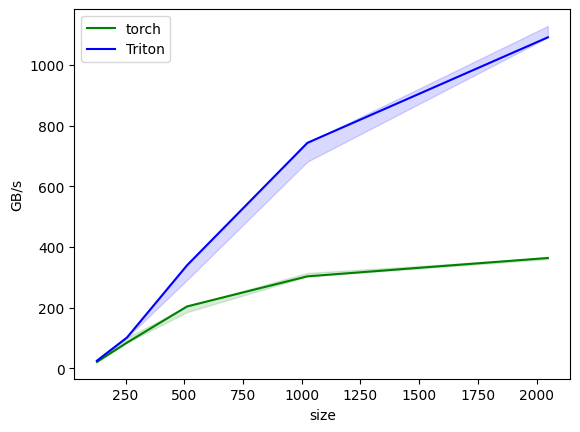

conv2d-performance-k3-fp32:
     size       torch       Triton
0   128.0   21.008463    25.210157
1   256.0   84.675127   101.610159
2   512.0  204.005083   340.008452
3  1024.0  303.167586   743.277338
4  2048.0  363.733892  1091.201720
None


In [249]:
# Configurate the benchmarks
configs = []
ref_lib = "torch"
kernel_sizes = [3]
sizes = [128, 256, 512, 1024, 2048]  # Use same values for both height and width

for ksz in kernel_sizes:
    configs.append(
        triton.testing.Benchmark(
            x_names=["size"],  # Single x-axis parameter that will be used for both height and width
            x_vals=sizes,     # Different possible values for the size
            line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
            line_vals=[ref_lib.lower(), "triton"],  # Label name for the lines
            line_names=[ref_lib, "Triton"],  # Line styles
            styles=[("green", "-"), ("blue", "-")],
            ylabel="GB/s",  # Label name for the y-axis
            plot_name=f"conv2d-performance-k{ksz}-fp32",  # Name for the plot
            args={"kH": ksz, "kW": ksz},
        ))
@triton.testing.perf_report(configs)
def benchmark(size, provider, kH, kW):
    # Use size for both height and width
    height = size
    width = size
    
    stride = 1
    input_tensor = torch.randn(height, width, device='cuda', dtype=torch.float32)
    kernel_tensor = torch.randn(kH, kW, device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    
    if provider == ref_lib.lower():
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: F.conv2d(input_tensor[None, None, :, :], kernel_tensor[None, None, :, :]), 
            quantiles=quantiles
        )
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: conv2d(input_tensor, kernel_tensor, height=height, width=width, kH=kH, kW=kW, stride=stride),
            quantiles=quantiles
        )
    
    # Calculate memory bandwidth
    bytes_per_element = 4  # float32
    
    # Input tensor size: H * W
    input_size = height * width
    
    # Kernel tensor size: kH * kW
    kernel_size = kH * kW
    
    # Output tensor size: (H-kH+1) * (W-kW+1)
    out_height = (height - kH) // stride + 1
    out_width = (width - kW) // stride + 1
    output_size = out_height * out_width
    
    # Total bytes accessed
    bytes_accessed = (input_size + kernel_size + output_size) * bytes_per_element
    
    # Convert to GB/s
    gb_per_s = lambda ms: bytes_accessed * 1e-9 / (ms * 1e-3)
    
    return gb_per_s(ms), gb_per_s(max_ms), gb_per_s(min_ms)

# Run the benchmark
print(benchmark.run(show_plots=True, print_data=True))

In [250]:
conv2d_kernel.best_config.num_stages

3